In [1]:
!nvidia-smi

Wed Aug  7 02:24:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 30%   34C    P8              24W / 300W |      1MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Load files

In [2]:
stereoset_results_dir = '../results/stereoset_SelfDebias_processed'
crows_results_dir = '../results/crows_SelfDebias'

before_debias_stereoset_results_dir = '../results/stereoset_processed'
phi_before_debias_crows_results_dir = '../results/crows'

In [3]:
import os
import json

stereoset_results = {'llama2': {},
                     'gpt2': {},
                     'phi2': {}}
# Load all data
for file in os.listdir(stereoset_results_dir):
    if file.endswith('.json'):
        if any(x in file for x in ['gender', 'race-color', 'religion']):
            category = 'gender' if 'gender' in file else 'race' if 'race-color' in file else 'religion'
            with open(os.path.join(stereoset_results_dir, file)) as f:
                loaded = json.load(f)
                loaded = loaded[list(loaded.keys())[0]]['intrasentence'][category]
                if 'Llama-2' in file:
                    stereoset_results['llama2'] = {**stereoset_results['llama2'],
                                                   category : loaded}
                elif 'GPT2' in file:
                    stereoset_results['gpt2'] = {**stereoset_results['gpt2'],
                                                 category : loaded}
                elif 'Phi2' in file:
                    stereoset_results['phi2'] = {**stereoset_results['phi2'],
                                                 category : loaded}
                
# Load crows results
crows_results = {'llama2': {},
                 'gpt2': {},
                 'phi2': {}}
for file in os.listdir(crows_results_dir):
    if file.endswith('.json'):
        if any(x in file for x in ['gender', 'race-color', 'religion']):
            category = 'gender' if 'gender' in file else 'race' if 'race-color' in file else 'religion'
            with open(os.path.join(crows_results_dir, file)) as f:
                loaded = json.load(f)
                if 'Llama-2' in file:
                    crows_results['llama2'] = {**crows_results['llama2'],
                                               **loaded}
                elif 'GPT2' in file:
                    crows_results['gpt2'] = {**crows_results['gpt2'],
                                             **loaded}
                elif 'Phi2' in file:
                    crows_results['phi2'] = {**crows_results['phi2'],
                                             **loaded}
                    
# Load original results
# Crows
with open(f'{phi_before_debias_crows_results_dir}/crows_m-GPT2LMHeadModel_c-gpt2.json', 'r') as f:
    gpt2_before_crows_results = json.load(f)
with open(f'{phi_before_debias_crows_results_dir}/crows_m-PhiForCausalLM_c-microsoft_phi-2.json', 'r') as f:
    phi2_before_crows_results = json.load(f)
with open(f'{phi_before_debias_crows_results_dir}/crows_m-LlamaForCausalLM_c-meta-llama_Llama-2-7b-hf.json', 'r') as f:
    llama2_before_crows_results = json.load(f)
    
# Combine into 1 dict
before_crows_results = {'gpt2': gpt2_before_crows_results,
                        'phi2': phi2_before_crows_results,
                        'llama2': llama2_before_crows_results}
    
# Stereoset
with open(f'{before_debias_stereoset_results_dir}/stereoset_m-GPT2LMHeadModel_c-gpt2_s-42.json', 'r') as f:
    gpt2_before_stereoset_results = json.load(f)
with open(f'{before_debias_stereoset_results_dir}/stereoset_m-LlamaForCausalLM_c-meta-llama_Llama-2-7b-hf_s-42.json', 'r') as f:
    llama2_before_stereoset_results = json.load(f)
with open(f'{before_debias_stereoset_results_dir}/stereoset_m-PhiForCausalLM_c-microsoft_phi-2_s-42.json', 'r') as f:
    phi2_before_stereoset_results = json.load(f)
    
# Combine into 1 dict
before_stereoset_results = {'gpt2': gpt2_before_stereoset_results[list(gpt2_before_stereoset_results.keys())[0]]['intrasentence'],
                            'phi2': phi2_before_stereoset_results[list(phi2_before_stereoset_results.keys())[0]]['intrasentence'],
                            'llama2': llama2_before_stereoset_results[list(llama2_before_stereoset_results.keys())[0]]['intrasentence']}

def filter_categories(data, categories):
    return {
        model: {
            category: values
            for category, values in model_data.items()
            if category in categories
        }
        for model, model_data in data.items()
    }
# Filter the dictionary
before_stereoset_results = filter_categories(before_stereoset_results, ['gender', 'race', 'religion'])
before_crows_results = filter_categories(before_crows_results, ['gender', 'race-color', 'religion'])

# Plot gpt2 before and after self-debias

/tmp/ipykernel_732885/978708807.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles + [angles[0]], close_line(gpt2), 'o-', color=gpt2_color, linewidth=2, linestyle=':', label='GPT-2 (Original)')


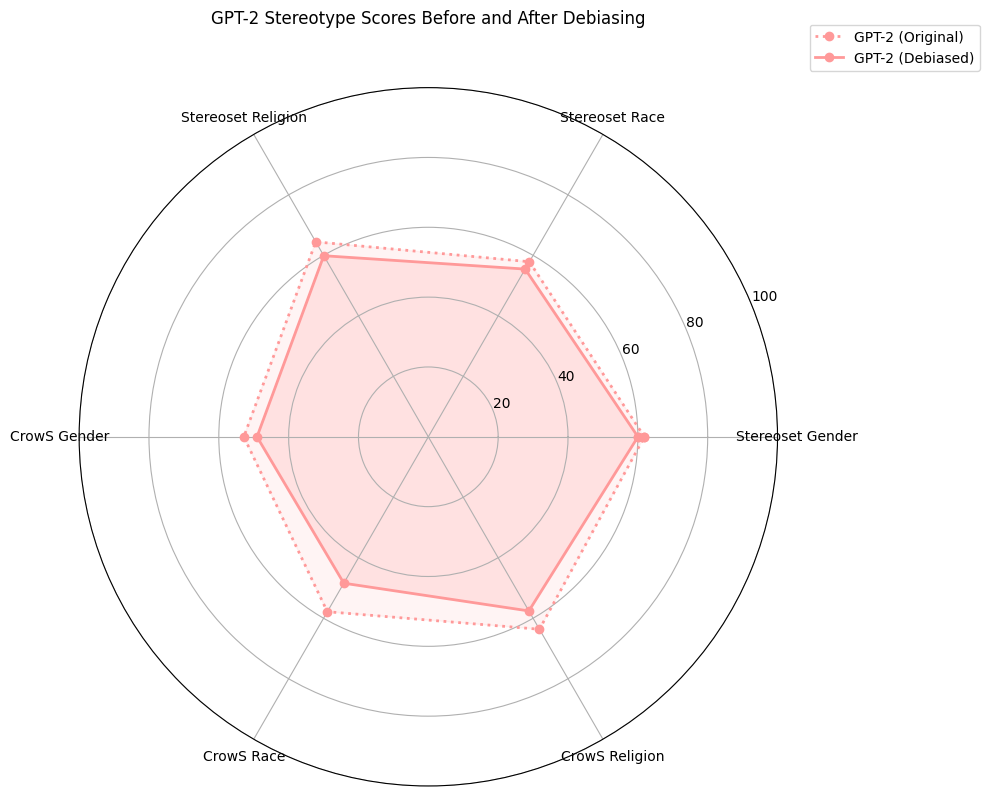

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract stereotype scores for GPT-2
def extract_gpt2_stereotype_scores(original_stereo, debiased_stereo, original_crows, debiased_crows):
    return [
        original_stereo['gpt2']['gender']['SS Score'],
        original_stereo['gpt2']['race']['SS Score'],
        original_stereo['gpt2']['religion']['SS Score'],
        original_crows['gpt2']['gender']['Stereotype score'],
        original_crows['gpt2']['race-color']['Stereotype score'],
        original_crows['gpt2']['religion']['Stereotype score']
    ], [
        debiased_stereo['gpt2']['gender']['SS Score'],
        debiased_stereo['gpt2']['race']['SS Score'],
        debiased_stereo['gpt2']['religion']['SS Score'],
        debiased_crows['gpt2']['gender']['Stereotype score'],
        debiased_crows['gpt2']['race-color']['Stereotype score'],
        debiased_crows['gpt2']['religion']['Stereotype score']
    ]

categories = ['Stereoset Gender', 'Stereoset Race', 'Stereoset Religion', 
              'CrowS Gender', 'CrowS Race', 'CrowS Religion']

# Extract stereotype scores for GPT-2
gpt2, gpt2_debiased = extract_gpt2_stereotype_scores(before_stereoset_results, stereoset_results, before_crows_results, crows_results)

# Number of variables
num_vars = len(categories)

# Compute angle for each variable
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
def close_line(line):
    return np.concatenate((line, [line[0]]))

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Define colors for GPT-2
gpt2_color = '#FF9999'

# Plot data
ax.plot(angles + [angles[0]], close_line(gpt2), 'o-', color=gpt2_color, linewidth=2, linestyle=':', label='GPT-2 (Original)')
ax.plot(angles + [angles[0]], close_line(gpt2_debiased), 'o-', color=gpt2_color, linewidth=2, label='GPT-2 (Debiased)')

# Fill the area
ax.fill(angles + [angles[0]], close_line(gpt2), color=gpt2_color, alpha=0.1)
ax.fill(angles + [angles[0]], close_line(gpt2_debiased), color=gpt2_color, alpha=0.2)

# Set category labels
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Set y-axis limits
ax.set_ylim(0, 100)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('GPT-2 Stereotype Scores Before and After Debiasing', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/self_debias/before_after_gpt2.png')

# Plot phi2 before and after self-debias

/tmp/ipykernel_732885/1563669552.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles + [angles[0]], close_line(phi2), 'o-', color=phi2_color, linewidth=2, linestyle=':', label='Phi-2 (Original)')


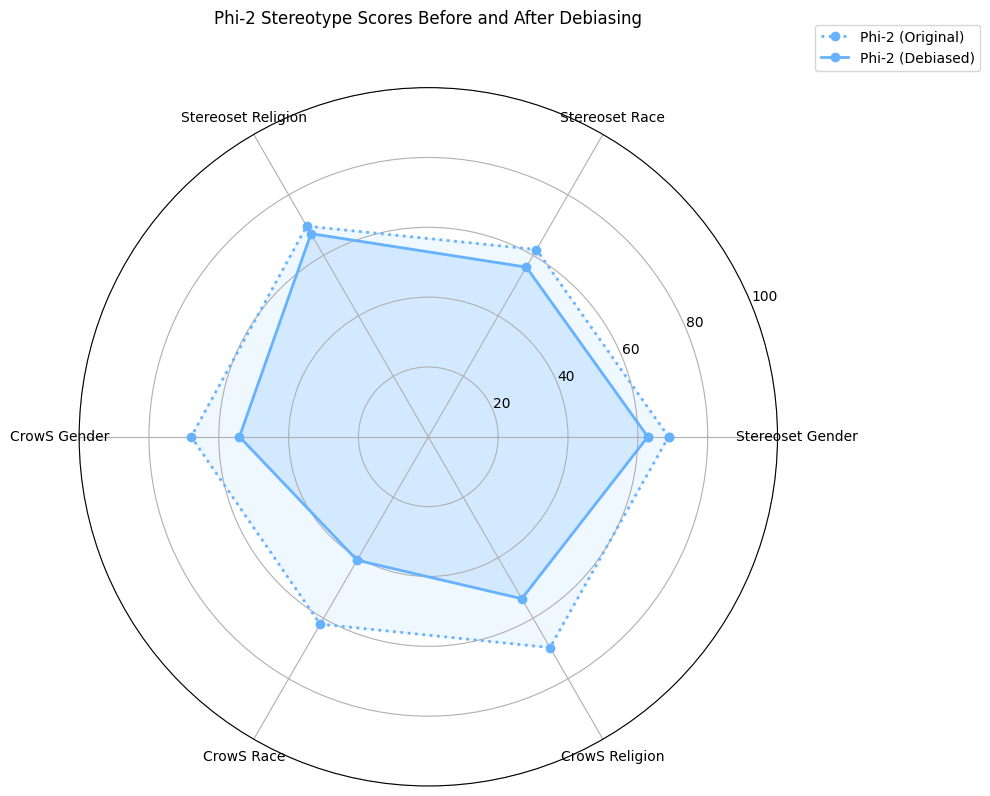

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract stereotype scores for Phi-2
def extract_phi2_stereotype_scores(original_stereo, debiased_stereo, original_crows, debiased_crows):
    return [
        original_stereo['phi2']['gender']['SS Score'],
        original_stereo['phi2']['race']['SS Score'],
        original_stereo['phi2']['religion']['SS Score'],
        original_crows['phi2']['gender']['Stereotype score'],
        original_crows['phi2']['race-color']['Stereotype score'],
        original_crows['phi2']['religion']['Stereotype score']
    ], [
        debiased_stereo['phi2']['gender']['SS Score'],
        debiased_stereo['phi2']['race']['SS Score'],
        debiased_stereo['phi2']['religion']['SS Score'],
        debiased_crows['phi2']['gender']['Stereotype score'],
        debiased_crows['phi2']['race-color']['Stereotype score'],
        debiased_crows['phi2']['religion']['Stereotype score']
    ]

categories = ['Stereoset Gender', 'Stereoset Race', 'Stereoset Religion', 
              'CrowS Gender', 'CrowS Race', 'CrowS Religion']

# Extract stereotype scores for Phi-2
phi2, phi2_debiased = extract_phi2_stereotype_scores(before_stereoset_results, stereoset_results, before_crows_results, crows_results)

# Number of variables
num_vars = len(categories)

# Compute angle for each variable
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
def close_line(line):
    return np.concatenate((line, [line[0]]))

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Define colors for Phi-2
phi2_color = '#66B2FF'

# Plot data
ax.plot(angles + [angles[0]], close_line(phi2), 'o-', color=phi2_color, linewidth=2, linestyle=':', label='Phi-2 (Original)')
ax.plot(angles + [angles[0]], close_line(phi2_debiased), 'o-', color=phi2_color, linewidth=2, label='Phi-2 (Debiased)')

# Fill the area
ax.fill(angles + [angles[0]], close_line(phi2), color=phi2_color, alpha=0.1)
ax.fill(angles + [angles[0]], close_line(phi2_debiased), color=phi2_color, alpha=0.2)

# Set category labels
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Set y-axis limits
ax.set_ylim(0, 100)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('Phi-2 Stereotype Scores Before and After Debiasing', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/self_debias/before_after_phi2.png')

# Llama 2

/tmp/ipykernel_732885/4001159977.py:45: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles + [angles[0]], close_line(llama2), 'o-', color=llama2_color, linewidth=2, linestyle=':', label='LLaMA 2 (Original)')


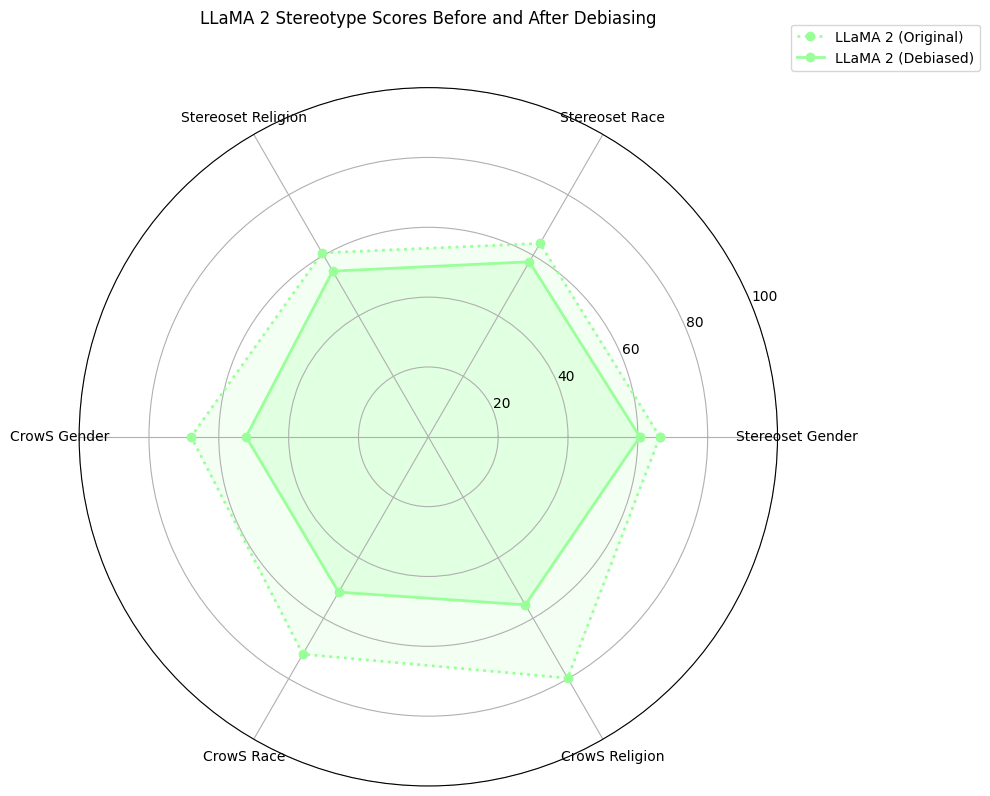

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract stereotype scores for LLaMA 2
def extract_llama2_stereotype_scores(original_stereo, debiased_stereo, original_crows, debiased_crows):
    return [
        original_stereo['llama2']['gender']['SS Score'],
        original_stereo['llama2']['race']['SS Score'],
        original_stereo['llama2']['religion']['SS Score'],
        original_crows['llama2']['gender']['Stereotype score'],
        original_crows['llama2']['race-color']['Stereotype score'],
        original_crows['llama2']['religion']['Stereotype score']
    ], [
        debiased_stereo['llama2']['gender']['SS Score'],
        debiased_stereo['llama2']['race']['SS Score'],
        debiased_stereo['llama2']['religion']['SS Score'],
        debiased_crows['llama2']['gender']['Stereotype score'],
        debiased_crows['llama2']['race-color']['Stereotype score'],
        debiased_crows['llama2']['religion']['Stereotype score']
    ]

categories = ['Stereoset Gender', 'Stereoset Race', 'Stereoset Religion', 
              'CrowS Gender', 'CrowS Race', 'CrowS Religion']

# Extract stereotype scores for LLaMA 2
llama2, llama2_debiased = extract_llama2_stereotype_scores(before_stereoset_results, stereoset_results, before_crows_results, crows_results)

# Number of variables
num_vars = len(categories)

# Compute angle for each variable
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
def close_line(line):
    return np.concatenate((line, [line[0]]))

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Define colors for LLaMA 2
llama2_color = '#99FF99'

# Plot data
ax.plot(angles + [angles[0]], close_line(llama2), 'o-', color=llama2_color, linewidth=2, linestyle=':', label='LLaMA 2 (Original)')
ax.plot(angles + [angles[0]], close_line(llama2_debiased), 'o-', color=llama2_color, linewidth=2, label='LLaMA 2 (Debiased)')

# Fill the area
ax.fill(angles + [angles[0]], close_line(llama2), color=llama2_color, alpha=0.1)
ax.fill(angles + [angles[0]], close_line(llama2_debiased), color=llama2_color, alpha=0.2)

# Set category labels
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Set y-axis limits
ax.set_ylim(0, 100)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('LLaMA 2 Stereotype Scores Before and After Debiasing', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/self_debias/before_after_llama2.png')

# Plot stereoset & crows radar charts, before & after self-debias

/tmp/ipykernel_732885/3800357165.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles + [angles[0]], close_line(gpt2), 'o-', color=colors['gpt2'], linewidth=2, linestyle=':', label='GPT-2 (Original)')
/tmp/ipykernel_732885/3800357165.py:49: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles + [angles[0]], close_line(phi2), 'o-', color=colors['phi2'], linewidth=2, linestyle=':', label='Phi-2 (Original)')
/tmp/ipykernel_732885/3800357165.py:51: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles + [angles[0]], close_line(llama2), 'o-', color=colors['llama2'], linewidth=2, linestyle=':',

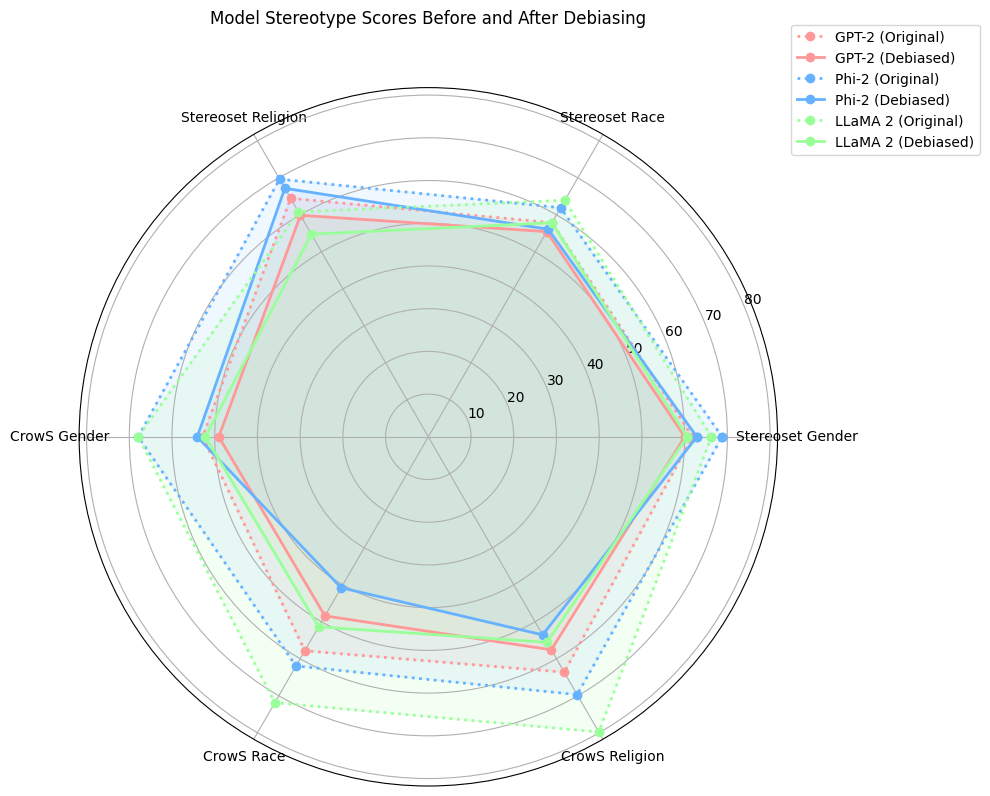

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract stereotype scores for a model
def extract_stereotype_scores(model, original_stereo, debiased_stereo, original_crows, debiased_crows):
    return [
        original_stereo[model]['gender']['SS Score'],
        original_stereo[model]['race']['SS Score'],
        original_stereo[model]['religion']['SS Score'],
        original_crows[model]['gender']['Stereotype score'],
        original_crows[model]['race-color']['Stereotype score'],
        original_crows[model]['religion']['Stereotype score']
    ], [
        debiased_stereo[model]['gender']['SS Score'],
        debiased_stereo[model]['race']['SS Score'],
        debiased_stereo[model]['religion']['SS Score'],
        debiased_crows[model]['gender']['Stereotype score'],
        debiased_crows[model]['race-color']['Stereotype score'],
        debiased_crows[model]['religion']['Stereotype score']
    ]

categories = ['Stereoset Gender', 'Stereoset Race', 'Stereoset Religion', 
              'CrowS Gender', 'CrowS Race', 'CrowS Religion']

# Extract stereotype scores for each model
gpt2, gpt2_debiased = extract_stereotype_scores('gpt2', before_stereoset_results, stereoset_results, before_crows_results, crows_results)
phi2, phi2_debiased = extract_stereotype_scores('phi2', before_stereoset_results, stereoset_results, before_crows_results, crows_results)
llama2, llama2_debiased = extract_stereotype_scores('llama2', before_stereoset_results, stereoset_results, before_crows_results, crows_results)

# Number of variables
num_vars = len(categories)

# Compute angle for each variable
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
def close_line(line):
    return np.concatenate((line, [line[0]]))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

# Define colors for each model
colors = {'gpt2': '#FF9999', 'phi2': '#66B2FF', 'llama2': '#99FF99'}

# Plot data
ax.plot(angles + [angles[0]], close_line(gpt2), 'o-', color=colors['gpt2'], linewidth=2, linestyle=':', label='GPT-2 (Original)')
ax.plot(angles + [angles[0]], close_line(gpt2_debiased), 'o-', color=colors['gpt2'], linewidth=2, label='GPT-2 (Debiased)')
ax.plot(angles + [angles[0]], close_line(phi2), 'o-', color=colors['phi2'], linewidth=2, linestyle=':', label='Phi-2 (Original)')
ax.plot(angles + [angles[0]], close_line(phi2_debiased), 'o-', color=colors['phi2'], linewidth=2, label='Phi-2 (Debiased)')
ax.plot(angles + [angles[0]], close_line(llama2), 'o-', color=colors['llama2'], linewidth=2, linestyle=':', label='LLaMA 2 (Original)')
ax.plot(angles + [angles[0]], close_line(llama2_debiased), 'o-', color=colors['llama2'], linewidth=2, label='LLaMA 2 (Debiased)')

# Fill the area
ax.fill(angles + [angles[0]], close_line(gpt2), color=colors['gpt2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(gpt2_debiased), color=colors['gpt2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(phi2), color=colors['phi2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(phi2_debiased), color=colors['phi2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(llama2), color=colors['llama2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(llama2_debiased), color=colors['llama2'], alpha=0.1)

# Set category labels
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('Model Stereotype Scores Before and After Debiasing', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/self_debias/all_model_comparision.png')

# Only plot debiased results

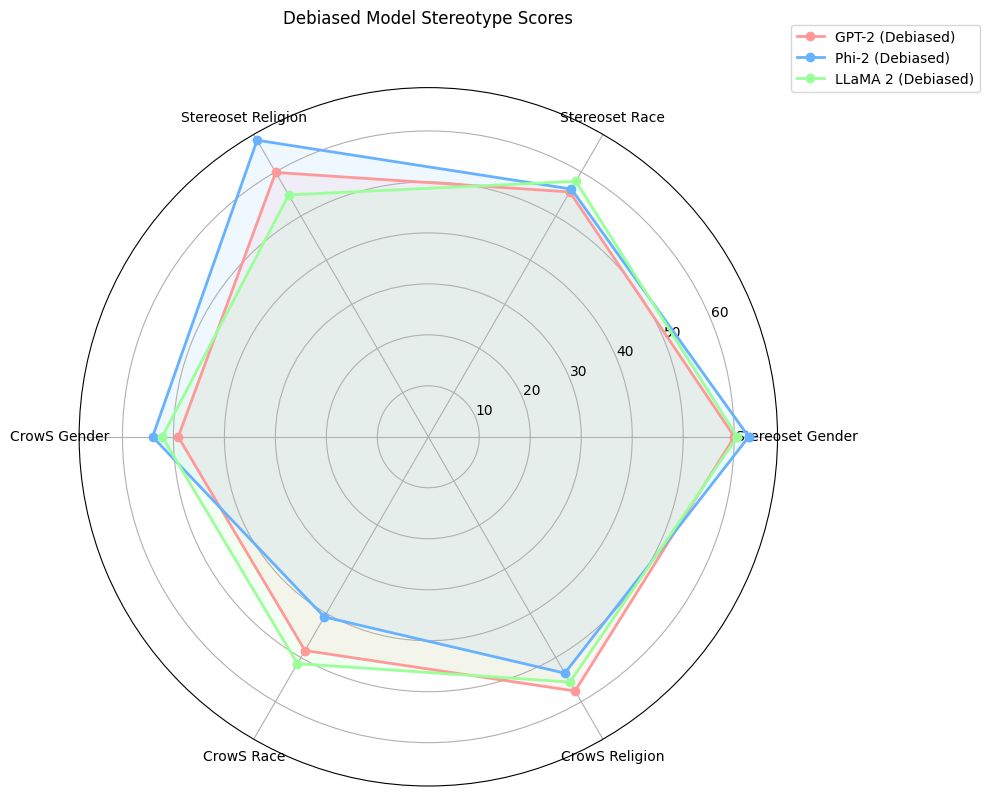

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract stereotype scores for a model
def extract_stereotype_scores(model, debiased_stereo, debiased_crows):
    return [
        debiased_stereo[model]['gender']['SS Score'],
        debiased_stereo[model]['race']['SS Score'],
        debiased_stereo[model]['religion']['SS Score'],
        debiased_crows[model]['gender']['Stereotype score'],
        debiased_crows[model]['race-color']['Stereotype score'],
        debiased_crows[model]['religion']['Stereotype score']
    ]

categories = ['Stereoset Gender', 'Stereoset Race', 'Stereoset Religion', 
              'CrowS Gender', 'CrowS Race', 'CrowS Religion']

# Extract stereotype scores for each debiased model
gpt2_debiased = extract_stereotype_scores('gpt2', stereoset_results, crows_results)
phi2_debiased = extract_stereotype_scores('phi2', stereoset_results, crows_results)
llama2_debiased = extract_stereotype_scores('llama2', stereoset_results, crows_results)

# Number of variables
num_vars = len(categories)

# Compute angle for each variable
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Close the plot by appending the first value to the end
def close_line(line):
    return np.concatenate((line, [line[0]]))

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

# Define colors for each model
colors = {'gpt2': '#FF9999', 'phi2': '#66B2FF', 'llama2': '#99FF99'}

# Plot data
ax.plot(angles + [angles[0]], close_line(gpt2_debiased), 'o-', color=colors['gpt2'], linewidth=2, label='GPT-2 (Debiased)')
ax.plot(angles + [angles[0]], close_line(phi2_debiased), 'o-', color=colors['phi2'], linewidth=2, label='Phi-2 (Debiased)')
ax.plot(angles + [angles[0]], close_line(llama2_debiased), 'o-', color=colors['llama2'], linewidth=2, label='LLaMA 2 (Debiased)')

# Fill the area
ax.fill(angles + [angles[0]], close_line(gpt2_debiased), color=colors['gpt2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(phi2_debiased), color=colors['phi2'], alpha=0.1)
ax.fill(angles + [angles[0]], close_line(llama2_debiased), color=colors['llama2'], alpha=0.1)

# Set category labels
ax.set_xticks(angles)
ax.set_xticklabels(categories)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Add title
plt.title('Debiased Model Stereotype Scores', y=1.08)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/self_debias/debiased_model_comparision.png')